## Surrogate modeling using machine learning - US (Behave)
- ML models trained to predict HROS, BROS, FROS with train and test loss curves
- SHAP analysis of feature importance for sensitivity analysis
- Comprehensive exploratory data analysis on input dataset (i.e., input variables and their relationships with ROS) which includes correlation matrices, feature importance, residual plots, and more visualization options

#### ML model (XGBoost)
- XGBoost regressor trained using datasets created from Rothermel (R) code by Vacchiano & Ascoli (2015)
- 3 individual XGBoost models trained for HROS, BROS, FROS prediction

Source: Vacchiano, G., & Ascoli, D. (2015). An implementation of the Rothermel fire spread model in the R programming language. Fire Technology, 51, 523-535.


#### SHAP
SHAP is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, representing the only possible consistent and locally accurate additive feature attribution method based on expectations 

(More details : http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions).

In [1]:
# Libraries
import os, glob, tqdm, joblib, warnings
from functools import partial
import pandas as pd
import numpy as np

# ML
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, cross_validate, GridSearchCV, RepeatedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.metrics import mean_absolute_percentage_error as mape

# Sensitivity analysis (Optimize ML and SHAP feature importance)
import optuna
import shap

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Hyperparameters
N_CORES = 1
SEED = 42
np.random.seed(SEED)

warnings.filterwarnings('ignore')

/Users/minho/opt/anaconda3/envs/c2fml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. HELPER FUNCTIONS FOR CROSS-VALIDATION

# Custom scoring functions for transformed and original scale evaluation
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def original_scale_rmse(y_true_log, y_pred_log):
    # Convert predictions back to original scale and calculate RMSE
    y_true_original = np.expm1(y_true_log)
    y_pred_original = np.expm1(y_pred_log)
    return np.sqrt(mean_squared_error(y_true_original, y_pred_original))

# Define scoring metrics
rmse_scorer = make_scorer(rmse, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score, greater_is_better=True)

# Function to prepare data and apply target transformation
def prepare_data(df, target_column='HROS', log_transform=True):
    """
    Prepare dataset for modeling by optionally log-transforming the target
    """
    # Handle the skewed target (optional log transform)
    if log_transform:
        df[f'{target_column}_log'] = np.log1p(df[target_column])
        y = df[f'{target_column}_log']
    else:
        y = df[target_column]
    
    # Features
    X = df.drop([target_column], axis=1)
    if log_transform:
        X = X.drop([f'{target_column}_log'], axis=1, errors='ignore')
    
    return X, y

# Optuna hyperparameter optimization with cross-validation
def optimize_hyperparams_with_optuna(X, y, model_class, param_space, n_trials=50, cv=5):
    """
    Optimize hyperparameters using Optuna with cross-validation.
    """
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Define objective function for Optuna
    def objective(trial):
        # Create parameter dictionary from trial suggestions
        params = {}
        for param, spec in param_space.items():
            if spec[0] == 'categorical':
                params[param] = trial.suggest_categorical(param, spec[1])
            elif spec[0] == 'int':
                params[param] = trial.suggest_int(param, spec[1], spec[2], step=spec[3] if len(spec) > 3 else 1)
            elif spec[0] == 'float':
                params[param] = trial.suggest_float(param, spec[1], spec[2], log=spec[3] if len(spec) > 3 else False)
        
        # Create model with trial parameters
        model = model_class(**params)
        
        # Perform cross-validation
        cv_folds = KFold(n_splits=cv, shuffle=True, random_state=42)
        scores = cross_val_score(
            model, X_scaled, y, 
            scoring=rmse_scorer,
            cv=cv_folds, 
            n_jobs=-1
        )
        
        # Return mean RMSE (negative because Optuna minimizes)
        return -np.mean(scores)
    
    # Create study and optimize
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    
    # Return best parameters
    return study.best_params

# Train final model with best hyperparameters
def train_final_model(X, y, model_class, best_params):
    """
    Train the final model using the entire dataset.
    """
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and train model
    model = model_class(**best_params)
    model.fit(X_scaled, y, verbose=False)
    
    return model, scaler

def prepare_plot(all_results=None, all_epochs=None, set_name=None, loss_name=None):

    loss_list = [all_results[i][set_name][loss_name] for i in range(len(all_results))]
    epochs_list = [all_epochs[i] for i in range(len(all_epochs))]

    df_train_rmse = pd.DataFrame({'loss': loss_list, 'epochs': epochs_list})

    data = []
    # Iterate over each row in the DataFrame
    for index, row in df_train_rmse.iterrows():
        # Zip the epochs and loss lists together and append them to the data list
        data.extend(zip(row['epochs'], row['loss']))

    # Create a new DataFrame from the data list with columns 'epoch' and 'loss'
    new_df = pd.DataFrame(data, columns=['epoch', 'loss'])

    return new_df

''' Plot all trials as line plot '''
def plot_loss_curves(df_train=None, df_test=None, thresh=0, y_thresh=0.5, ros_mode=None, loss_name=None, save=False, output_path=None):
    fig, ax = plt.subplots(figsize=(10, 7))

    sns.lineplot(df_train, x ='epoch', y='loss', color='k', label='Train', legend=False, ax=ax)
    sns.lineplot(df_test, x ='epoch', y='loss', color='r', label='Test', legend=False, ax=ax)

    ax.set_xlabel('Epochs', size=20)
    ax.set_ylabel('Loss ({})'.format(loss_name), size=20)
    ax.set_title(ros_mode, size=24)
    # ax.legend(loc='best')
    # ax.legend(fontsize=18)  # Increase legend label size

    # Inset plot
    inset_ax = ax.inset_axes([0.65, 0.6, 0.3, 0.3])
    sns.lineplot(df_train, x ='epoch', y='loss', color='k', label='Train', legend=False, ax=inset_ax)
    sns.lineplot(df_test, x ='epoch', y='loss', color='r', label='Test', legend=False, ax=inset_ax)
    inset_ax.set_ylabel('Loss ({})'.format(loss_name), size=16) 
    inset_ax.set_xlabel('')
    inset_ax.set_ylim([0,y_thresh])
    inset_ax.set_title('Close-up plot', size=20)
    inset_ax.legend(fontsize=14)  # Increase legend label size

    # Inset plot2
    df_train['diff'] = df_train['loss'] - df_test['loss']
    
    inset_ax2 = ax.inset_axes([0.65, 0.18, 0.3, 0.3])
    # inset_ax2 = inset_axes(ax, width="30%", height="30%", borderpad=3, loc='upper right')
    sns.lineplot(x=df_train[thresh:]['epoch'], y=df_train[thresh:]['diff'], color='k', label='Difference', legend=False, ax=inset_ax2)
    inset_ax2.set_ylabel('$Loss_{train}$ - $Loss_{test}$', size=16) 
    inset_ax2.set_xlabel('Epochs', size=16)
    inset_ax2.set_xlim(df_train['epoch'][thresh], df_train['epoch'].iloc[-1])
    inset_ax2.set_title('Train loss - test loss', size=20)

    ax.tick_params(axis='both', labelsize=20)  # Increase tick label size
    inset_ax.tick_params(axis='both', labelsize=14)  # Increase tick label size
    inset_ax2.tick_params(axis='both', labelsize=14)  # Increase tick label size
    

    if save:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()

#### Paths

In [3]:
BASE_PATH = '/Users/minho/Documents/GitHub/Cell2FireML/'
DATA_PATH = os.path.join(BASE_PATH, 'data')

#### Define realistic parameter space by wind speed and slope
- Wind speed and slope parameters taken from Plischke et al. (2021)

Source: Plischke, E., Rabitti, G., & Borgonovo, E. (2021). Computing Shapley effects for sensitivity analysis. SIAM/ASA Journal on Uncertainty Quantification, 9(4), 1411-1437.

In [4]:
# Wind speed -- Lognormal parameters
mu = 2.9534
sigma = 0.5569

# Z-score for the 99th percentile
z_p = 2.33  # Approximate z-score for the 99th percentile

# Calculate the 99th percentile value
max_ws = np.exp(mu + sigma * z_p) 
print(f"99th Percentile (max practical value): {max_ws}")

# Slope -- Parameters for normal distribution
mu = 0.38
sigma = 0.186

# 99th percentile z-score
z_99 = norm.ppf(0.99)

# Find the maximum value of tan(φ) at the 99th percentile
max_tan_phi = mu + z_99 * sigma
print(f"Maximum tan(φ) value: {max_tan_phi}")

# Convert tan(φ) to an angle in radians
phi_radians = np.arctan(max_tan_phi)

# Convert radians to degrees
max_slope = np.degrees(phi_radians)
print(f"Maximum angle (φ) in degrees: {max_slope}")

99th Percentile (max practical value): 70.17393880427421
Maximum tan(φ) value: 0.8127007045715964
Maximum angle (φ) in degrees: 39.10078497849973


#### ML model training and optimization
- XGBoost model trained and optimized using Optuna (Objective to minimize MSE and cross-validated for fine-tuned hyperparameters)
- XGBoost model predictions on test set (20% split) to ensure reliable accuracy
- SHAP analysis on sampled dataset to find feature importance (by Shapley values)

In [5]:
# Set Parameters 
all_results, all_epochs = [],[]                         # Placeholders
drop_var = ['wd', 'mc10', 'mc100', 'mcHerb', 'mcWoody'] # Select variables to drop (if unnecessary)
save_option = True

### XGBoost training and optimization parameters (Optuna)

# XGBoost parameter space
xgb_param_space = {
    'n_estimators': ('int', 50, 1000, 10),
    'learning_rate': ('float', 0.001, 0.3, True),
    'max_depth': ('int', 3, 100),
    'subsample': ('float', 0.5, 1.0),
    'colsample_bytree': ('float', 0.5, 1.0),
    'min_child_weight': ('int', 1, 10),
    'reg_alpha': ('float', 0, 5),
    'reg_lambda': ('float', 0, 5)
}

n_trials = 100  # Number of Optuna trials
num_CV = 5      # Number of cross-validation folds

# SHAPLEY
shap_sample_size = 10000

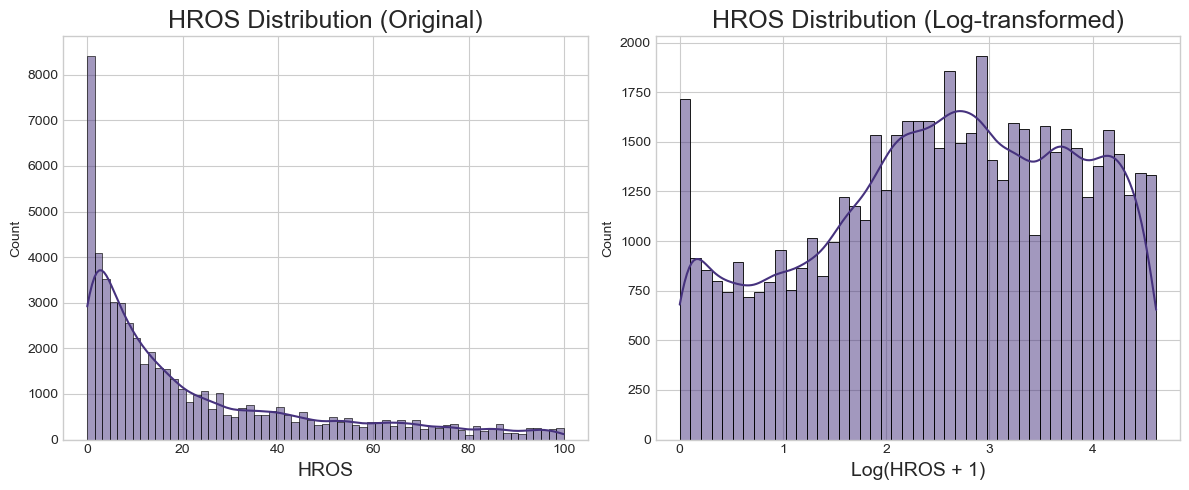

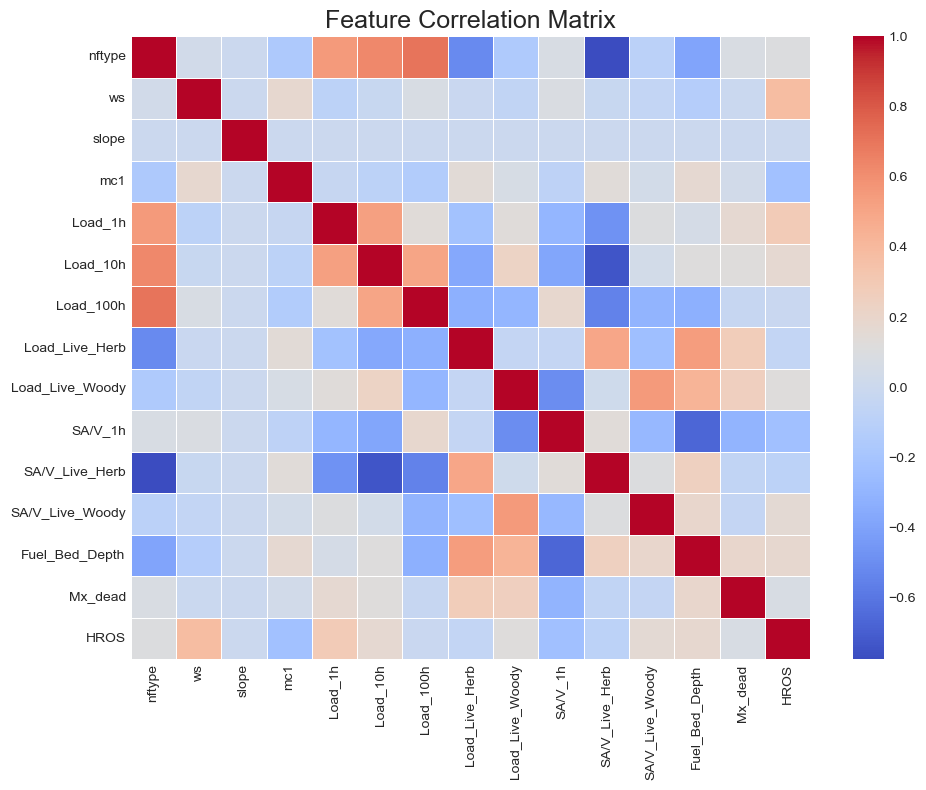

[I 2025-04-10 08:29:04,394] A new study created in memory with name: no-name-84dfaabd-4dfd-41ba-b66c-895587f91c3c
[I 2025-04-10 08:29:22,558] Trial 0 finished with value: 0.8274909851354801 and parameters: {'n_estimators': 620, 'learning_rate': 0.001093893373871666, 'max_depth': 55, 'subsample': 0.6170195244386968, 'colsample_bytree': 0.7062129742543672, 'min_child_weight': 8, 'reg_alpha': 1.7077595593467854, 'reg_lambda': 1.6904088806255873}. Best is trial 0 with value: 0.8274909851354801.
[I 2025-04-10 08:29:56,669] Trial 1 finished with value: 0.32198277135671 and parameters: {'n_estimators': 960, 'learning_rate': 0.0019000871594088084, 'max_depth': 19, 'subsample': 0.7599680651844029, 'colsample_bytree': 0.8096573562526512, 'min_child_weight': 2, 'reg_alpha': 0.23006777467310058, 'reg_lambda': 1.5551183561715813}. Best is trial 1 with value: 0.32198277135671.
[I 2025-04-10 08:30:15,202] Trial 2 finished with value: 0.04259493095043784 and parameters: {'n_estimators': 830, 'learning

  n_estimators: 830
  learning_rate: 0.06586369559662947
  max_depth: 87
  subsample: 0.5040309935580392
  colsample_bytree: 0.5508575239098142
  min_child_weight: 10
  reg_alpha: 0.010023694025729002
  reg_lambda: 1.4872374417245509

Training final model with optimal hyperparameters...

Example prediction:
Prediction results for sample data:


,Actual_ROS,Predicted_ROS,Error,Percent_Error
0,0.27,0.263633,0.006367,2.358243
1,0.12,0.116475,0.003525,2.937741
2,0.02,0.023132,-0.003132,-15.661426
3,0.01,0.017925,-0.007925,-79.252140
4,0.30,0.288272,0.011728,3.909177
5,0.13,0.127381,0.002619,2.014996
6,0.02,0.020900,-0.000900,-4.501937
7,0.01,0.016681,-0.006681,-66.806821
8,0.37,0.376031,-0.006031,-1.630116
9,0.17,0.166704,0.003296,1.938728



Final Model Evaluation on Test Set:
RMSE (log scale): 0.0206
RMSE (original scale): 0.5376
R² (log scale): 0.9997
R² (original scale): 0.9995


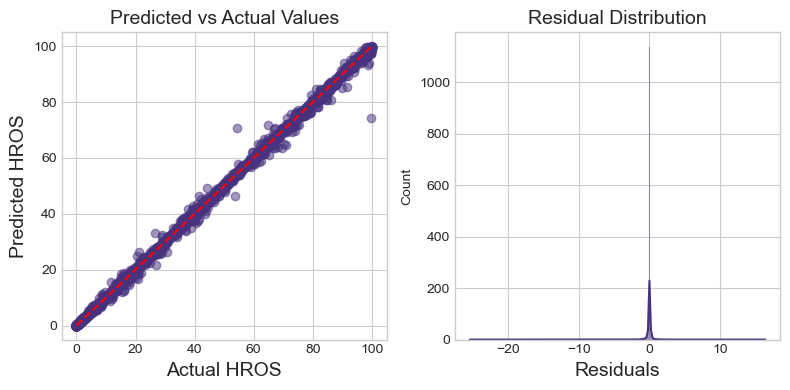

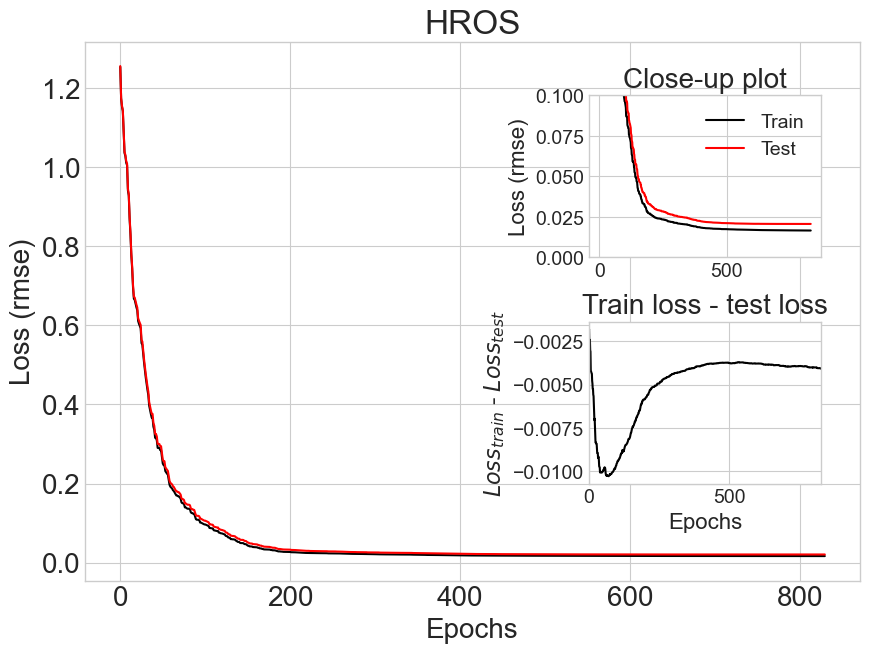

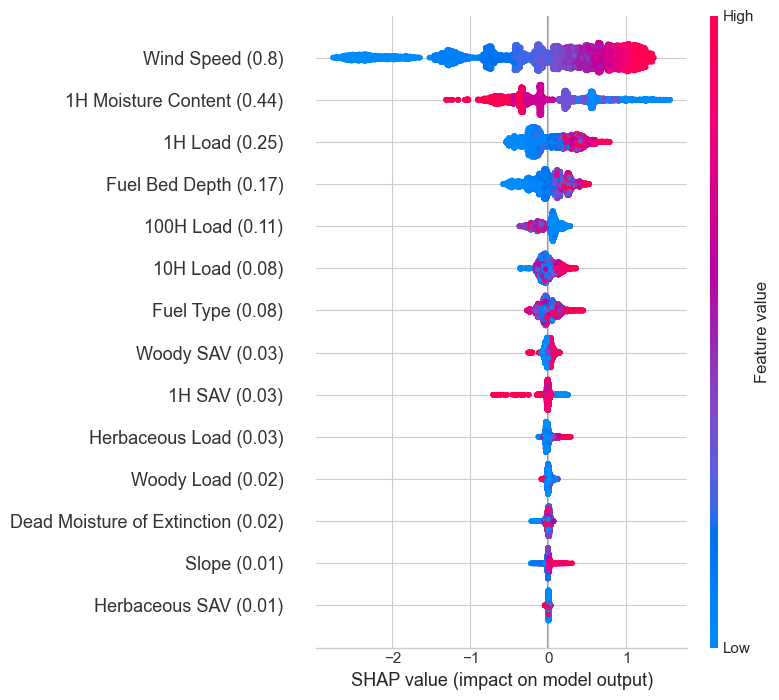

<Figure size 640x480 with 0 Axes>

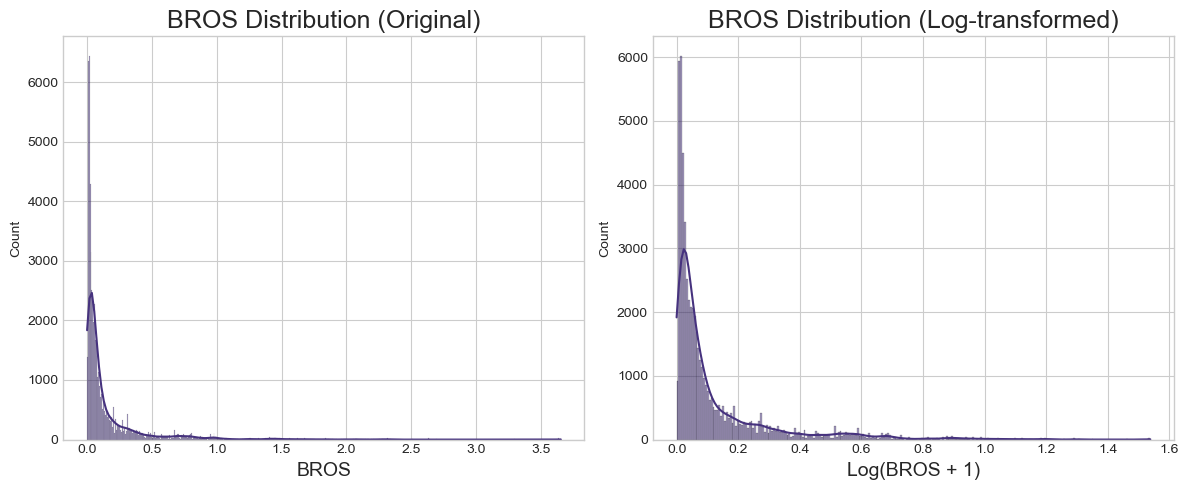

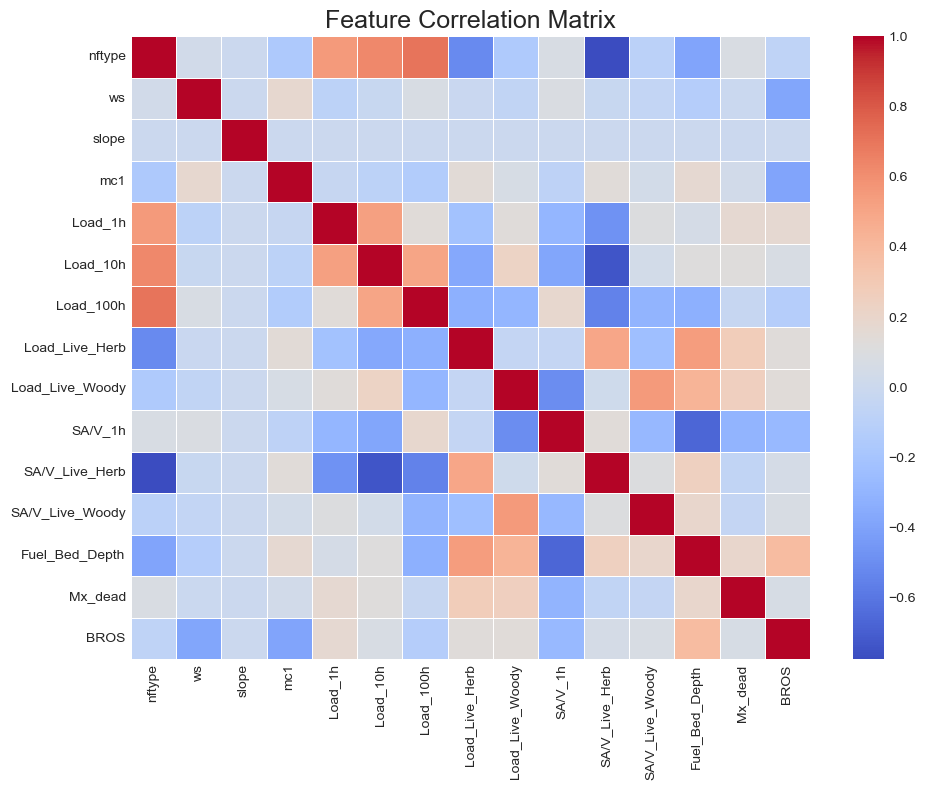

[I 2025-04-10 08:59:22,199] A new study created in memory with name: no-name-7423be6b-5b5c-412a-b200-38e6d6f99982
[I 2025-04-10 08:59:31,120] Trial 0 finished with value: 0.011243989283870251 and parameters: {'n_estimators': 400, 'learning_rate': 0.1816775557577192, 'max_depth': 79, 'subsample': 0.9515654038266835, 'colsample_bytree': 0.8604226674484914, 'min_child_weight': 1, 'reg_alpha': 4.842244287243292, 'reg_lambda': 4.347085174131832}. Best is trial 0 with value: 0.011243989283870251.
[I 2025-04-10 08:59:41,275] Trial 1 finished with value: 0.04551482990991652 and parameters: {'n_estimators': 640, 'learning_rate': 0.002849623733299524, 'max_depth': 16, 'subsample': 0.9229378710956035, 'colsample_bytree': 0.7868381647206429, 'min_child_weight': 2, 'reg_alpha': 1.1937938450282781, 'reg_lambda': 1.401723253508752}. Best is trial 0 with value: 0.011243989283870251.
[I 2025-04-10 08:59:45,744] Trial 2 finished with value: 0.007929649769281033 and parameters: {'n_estimators': 680, 'lea

  n_estimators: 880
  learning_rate: 0.055348029701410846
  max_depth: 85
  subsample: 0.6817064897907608
  colsample_bytree: 0.9290201961216031
  min_child_weight: 3
  reg_alpha: 0.0055239487245400025
  reg_lambda: 4.836812873769444

Training final model with optimal hyperparameters...

Example prediction:
Prediction results for sample data:


,Actual_ROS,Predicted_ROS,Error,Percent_Error
0,0.270000,0.272023,-0.002023,-0.749279
1,0.120000,0.119405,0.000595,0.496205
2,0.020000,0.018687,0.001313,6.566869
3,0.010000,0.010251,-0.000251,-2.512017
4,0.176043,0.175575,0.000468,0.265891
5,0.076285,0.076223,0.000063,0.082239
6,0.011736,0.011912,-0.000176,-1.501154
7,0.005868,0.007105,-0.001237,-21.082833
8,0.161613,0.161633,-0.000020,-0.012205
9,0.074255,0.074327,-0.000073,-0.097786



Final Model Evaluation on Test Set:
RMSE (log scale): 0.0013
RMSE (original scale): 0.0029
R² (log scale): 1.0000
R² (original scale): 0.9999


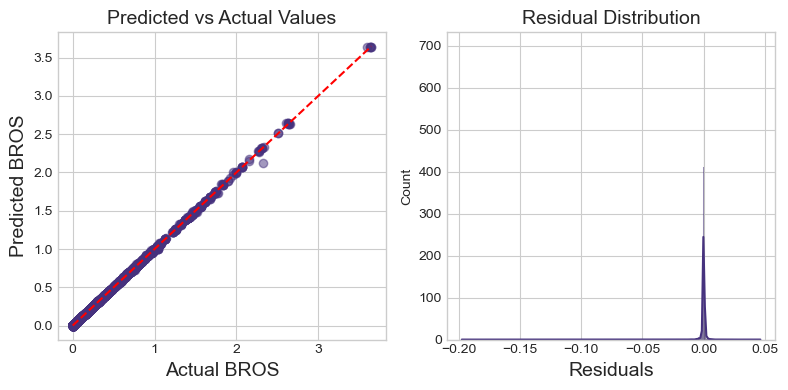

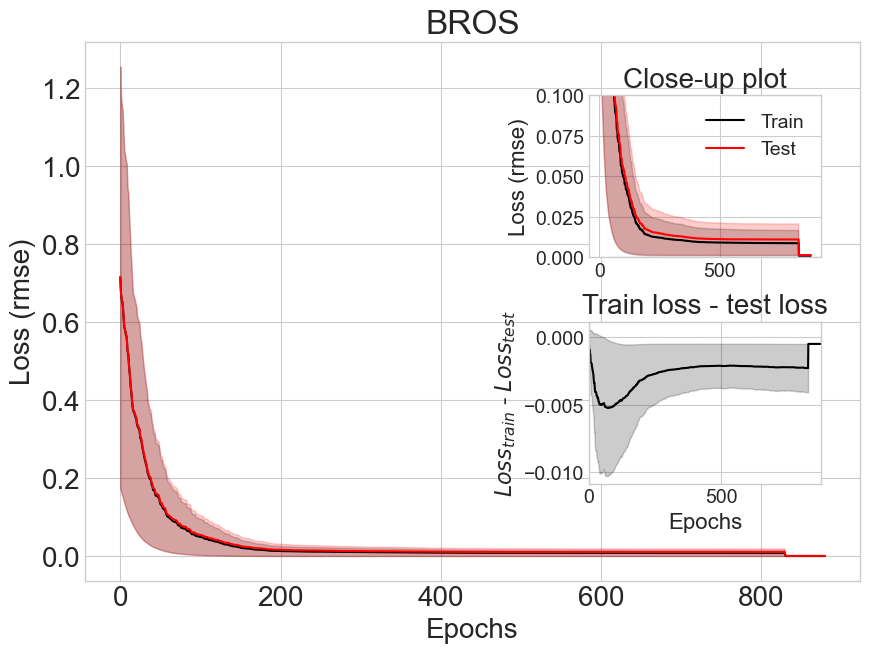

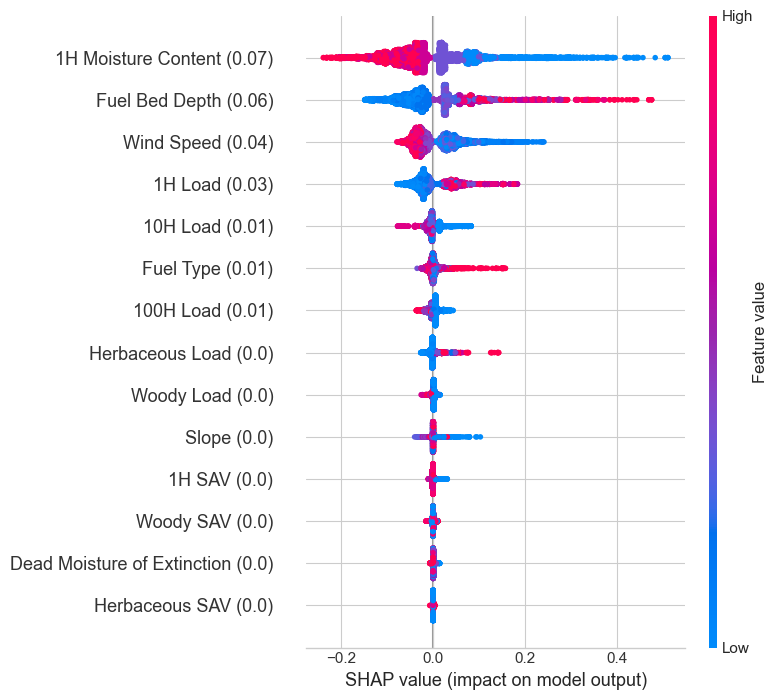

<Figure size 640x480 with 0 Axes>

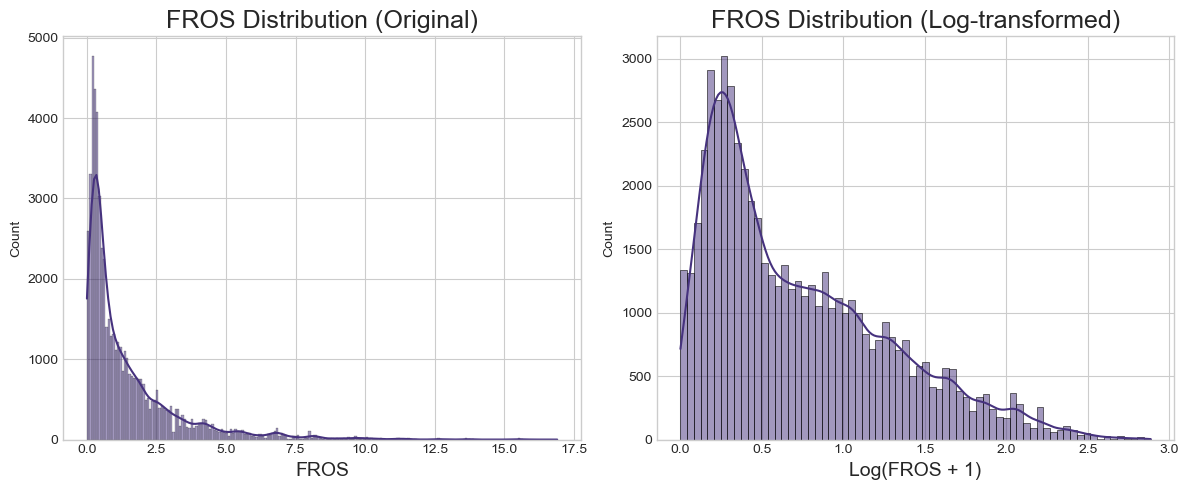

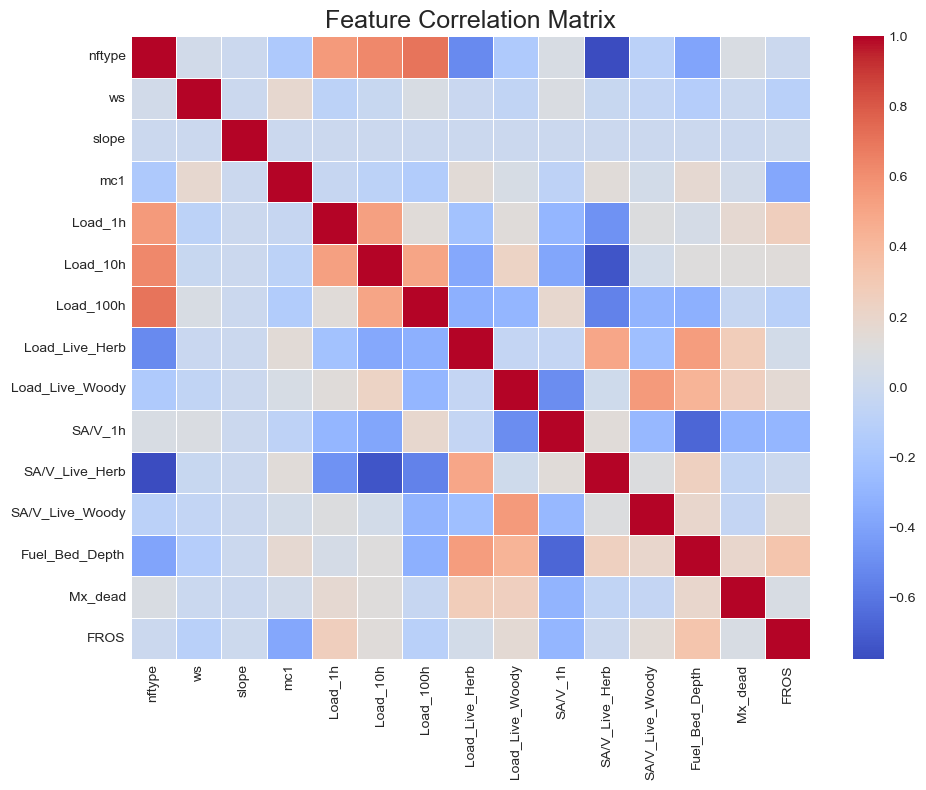

[I 2025-04-10 09:17:41,041] A new study created in memory with name: no-name-6ca39d0d-5493-40f7-aa12-ed81ce56d3e5
[I 2025-04-10 09:17:49,958] Trial 0 finished with value: 0.12368673779763488 and parameters: {'n_estimators': 150, 'learning_rate': 0.012336822489973637, 'max_depth': 100, 'subsample': 0.8180926405064306, 'colsample_bytree': 0.9219736551827027, 'min_child_weight': 5, 'reg_alpha': 1.5404081965989203, 'reg_lambda': 0.8816564189015746}. Best is trial 0 with value: 0.12368673779763488.
[I 2025-04-10 09:17:55,759] Trial 1 finished with value: 0.011481728516859512 and parameters: {'n_estimators': 920, 'learning_rate': 0.09400617269852114, 'max_depth': 38, 'subsample': 0.8129634314538645, 'colsample_bytree': 0.5425693718727768, 'min_child_weight': 7, 'reg_alpha': 0.8376478977226315, 'reg_lambda': 0.8017691060212029}. Best is trial 1 with value: 0.011481728516859512.
[I 2025-04-10 09:17:56,819] Trial 2 finished with value: 0.02193512978561125 and parameters: {'n_estimators': 240, '

  n_estimators: 780
  learning_rate: 0.061185603437953116
  max_depth: 9
  subsample: 0.5453614258591946
  colsample_bytree: 0.8520976205587589
  min_child_weight: 10
  reg_alpha: 0.06284540133417135
  reg_lambda: 3.7086332858147455

Training final model with optimal hyperparameters...

Example prediction:
Prediction results for sample data:


,Actual_ROS,Predicted_ROS,Error,Percent_Error
0,0.270000,0.264943,0.005057,1.872807
1,0.120000,0.123934,-0.003934,-3.278241
2,0.020000,0.021699,-0.001699,-8.496724
3,0.010000,0.011713,-0.001713,-17.126964
4,0.229811,0.230796,-0.000985,-0.428823
5,0.099585,0.100326,-0.000741,-0.744490
6,0.015321,0.015098,0.000223,1.454137
7,0.007660,0.009875,-0.002215,-28.913290
8,0.244534,0.244249,0.000285,0.116592
9,0.112354,0.110883,0.001470,1.308489



Final Model Evaluation on Test Set:
RMSE (log scale): 0.0074
RMSE (original scale): 0.0502
R² (log scale): 0.9998
R² (original scale): 0.9992


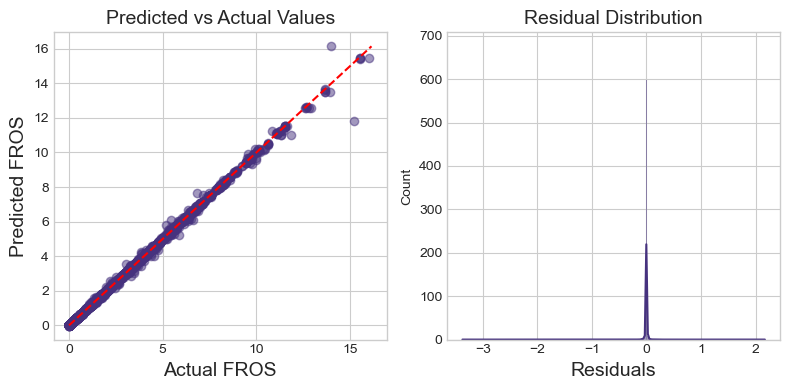

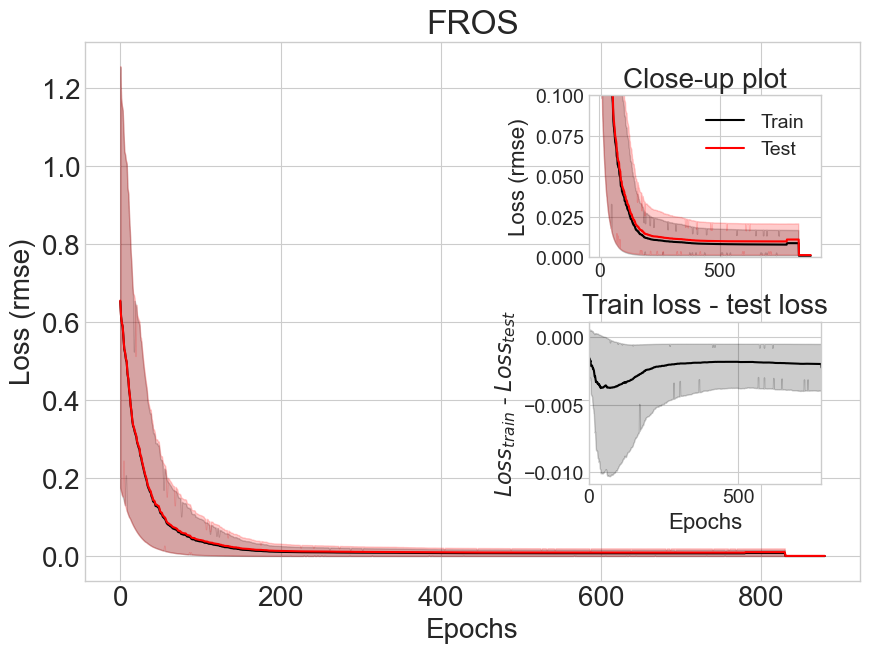

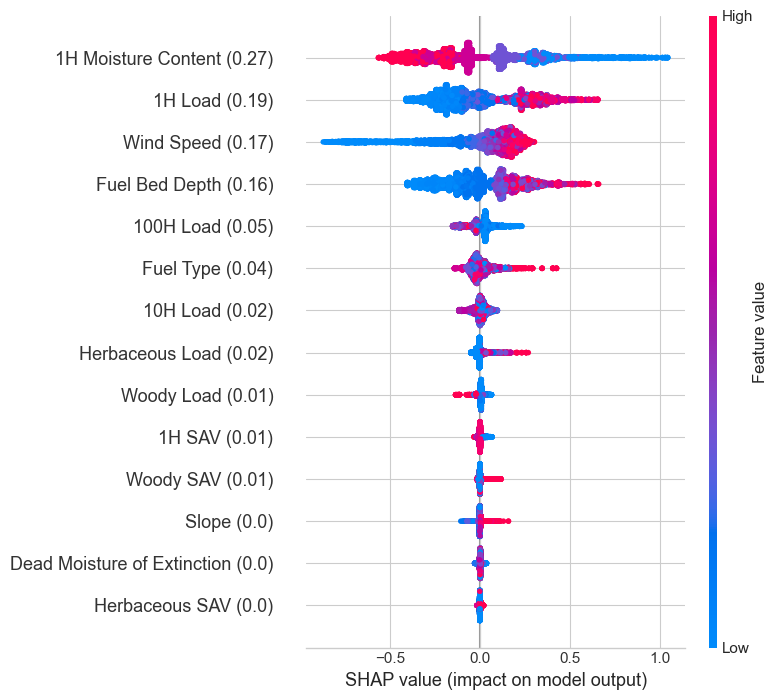

<Figure size 640x480 with 0 Axes>

In [23]:
# Train XGBoost for each ROS
for ros_mode in ["HROS", "BROS", "FROS"]:
    
    # Load data
    df = pd.read_csv(os.path.join(DATA_PATH, 'fsm/bp6_training_data.csv'))
    # Filter data based on max wind speed and slope to remove extreme outliers
    df = df[(df['ws'] < max_ws) & (df['slope'] < max_slope) & (df['HROS'] < 100)]   

    ### 1. DATA PREPROCESSING
    
    # Encode categorical data (i.e., Fuel type)
    label_encoder = LabelEncoder()
    encoded_feature = label_encoder.fit_transform(df['nftype'])
    df['nftype'] = encoded_feature        

    # Prepare label data (i.e., ROS values)
    ros_num = -3 if not ros_mode else -1

    if 'num' in df.columns:
        df = df.drop(columns = ['num'] + drop_var) 
    if ros_mode == "HROS" or ros_mode == "hros":
        df = df.drop(columns = ['BROS', 'FROS'])
    elif ros_mode == "BROS" or ros_mode == "bros":
        df = df.drop(columns = ['HROS', 'FROS'])
    elif ros_mode == "FROS" or ros_mode == "fros":
        df = df.drop(columns = ['BROS', 'HROS'])

    df = df.dropna().reset_index(drop=True)

    ### 2. VISUALIZE TARGET VARIABLE DISTRIBUTION
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df[ros_mode], kde=True)
    plt.title('{} Distribution (Original)'.format(ros_mode), size=18)
    plt.xlabel("{}".format(ros_mode), size=14)

    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(df[ros_mode]), kde=True)
    plt.title('{} Distribution (Log-transformed)'.format(ros_mode), size=18)
    plt.xlabel('Log({} + 1)'.format(ros_mode), size=14)

    plt.tight_layout()
    plt.show()


    # 3. CHECK CORRELATIONS
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Matrix', size=18)
    plt.tight_layout()
    plt.show()

    # # Focus on correlations with the target variable
    # plt.figure(figsize=(10, 4))
    # corr_with_target = correlation_matrix[ros_mode].sort_values(ascending=False)
    # corr_with_target = corr_with_target.drop(ros_mode)  # Remove self-correlation
    # sns.barplot(x=corr_with_target.index, y=corr_with_target.values)
    # plt.title('Feature Correlation with {}'.format(ros_mode), size=18)
    # plt.xticks(rotation=90)
    # plt.tight_layout()
    # plt.show()

    ### 4. PREPARE FOR HYPERPARAMETER OPTIMIZATION
    X, y = prepare_data(df, target_column=ros_mode, log_transform=True)
    model_class = xgb.XGBRegressor
    param_space = xgb_param_space
    base_params = {'objective': 'reg:squarederror', 'random_state': SEED}   

    ### 5. OPTIMIZE HYPERPARAMETERS WITH OPTUNA

    # Define model_class_with_base_params
    def create_model(**params):
        return model_class(**{**base_params, **params})

    # Set a smaller number of trials for demonstration
    best_params = optimize_hyperparams_with_optuna(
        X, y, 
        create_model, 
        param_space, 
        n_trials=n_trials, 
        cv=num_CV
    )
    for param, value in best_params.items():
        print(f"  {param}: {value}")

    print("\nTraining final model with optimal hyperparameters...")
    final_model_params = {**base_params, **best_params}
    final_model, scaler = train_final_model(X, y, model_class, final_model_params)

    # print("\nAnalyzing feature importance...")
    # plt.figure(figsize=(8, 4))

    # if hasattr(final_model, 'feature_importances_'):
    #     # These models have feature_importances_ attribute
    #     importances = final_model.feature_importances_
    #     indices = np.argsort(importances)
        
    #     plt.barh(range(len(indices)), importances[indices], align='center')
    #     plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
    #     # plt.title(f'Feature Importance ({best_model_name})')
    #     plt.xlabel('Relative Importance', size=14)
        
    #     # Display feature importances
    #     feature_importance_df = pd.DataFrame({
    #         'Feature': X.columns,
    #         'Importance': importances
    #     }).sort_values('Importance', ascending=False)

    # plt.tight_layout()
    # plt.show()

    ### 6. Predict ROS
    def predict_ros(new_data, model=final_model, scaler=scaler):
        """
        Make predictions using the trained XGBoost model.
        
        Parameters:
        -----------
        new_data : DataFrame
            New data for prediction (should have the same features as training data)
        model : estimator
            Trained model
        scaler : StandardScaler
            Fitted scaler
        
        Returns:
        --------
        predictions : array
            Predicted HROS values
        """
        # Scale features
        X_new_scaled = scaler.transform(new_data)
        
        # Predict (log scale)
        y_pred_log = model.predict(X_new_scaled)
        
        # Convert back to original scale
        y_pred = np.expm1(y_pred_log)
        
        return y_pred

    print("\nExample prediction:")
    # Create a sample for prediction
    new_data_sample = X.iloc[:10].copy()  # Take first 10 rows as an example

    # Make predictions
    predictions = predict_ros(new_data_sample)
    result_df = pd.DataFrame({
        'Actual_ROS': df[ros_mode].iloc[:10].values,
        'Predicted_ROS': predictions
    })
    result_df['Error'] = result_df['Actual_ROS'] - result_df['Predicted_ROS']
    result_df['Percent_Error'] = (result_df['Error'] / result_df['Actual_ROS']) * 100
    print("Prediction results for sample data:")
    display(result_df)

    ### 7. FINAL MODEL EVALUATION
    # Split data for a final holdout test (Split size fixed to 80% / 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

    # Scale features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model on training data
    final_eval_model = model_class(**final_model_params)
    results = final_eval_model.fit(X_train_scaled, y_train, eval_set=[(X_train_scaled,y_train), (X_test_scaled, y_test)], verbose=False)
    results_dict = results.evals_result()
    all_results.append(results_dict)
    all_epochs.append(np.arange(len(results_dict['validation_0']['rmse'])))

    # Predict on test data
    y_pred_log = final_eval_model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test)

    # Calculate metrics
    rmse_log = rmse(y_test, y_pred_log)
    rmse_orig = rmse(y_test_orig, y_pred)
    r2_log = r2_score(y_test, y_pred_log)
    r2_orig = r2_score(y_test_orig, y_pred)

    print("\nFinal Model Evaluation on Test Set:")
    print(f"RMSE (log scale): {rmse_log:.4f}")
    print(f"RMSE (original scale): {rmse_orig:.4f}")
    print(f"R² (log scale): {r2_log:.4f}")
    print(f"R² (original scale): {r2_orig:.4f}")

    # 15. VISUALIZE PREDICTIONS VS ACTUAL
    plt.figure(figsize=(8, 4))

    # Plot predictions vs actual values
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_orig, y_pred, alpha=0.5)
    plt.plot([0, max(y_test_orig.max(), y_pred.max())], 
            [0, max(y_test_orig.max(), y_pred.max())], 
            'r--')
    plt.xlabel('Actual {}'.format(ros_mode), size=14)
    plt.ylabel('Predicted {}'.format(ros_mode), size=14)
    plt.title('Predicted vs Actual Values', size=14)

    # Plot residuals
    plt.subplot(1, 2, 2)
    residuals = y_pred - y_test_orig
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals', size=14)
    plt.title('Residual Distribution', size=14)

    plt.tight_layout()
    plt.show()

    # Prepare data
    df_train_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_0', loss_name='rmse') # Train
    df_test_rmse = prepare_plot(all_results=all_results, all_epochs=all_epochs, set_name='validation_1', loss_name='rmse')  # Test

    # Plot visualizations
    plot_loss_curves(df_train=df_train_rmse, df_test=df_test_rmse, ros_mode=ros_mode, loss_name='rmse', y_thresh=0.1,
                    save=save_option, output_path=os.path.join(DATA_PATH, 'fsm', ros_mode + '_xgboost.png'))


    # Run SHAP
    fnames = ["Fuel Type",
            "Wind Speed",
            # "Wind Direction",
            "Slope",
            "1H Moisture Content",
            # "10H Moisture Content",
            # "100H Moisture Content",
            # "Herbaceous Moisture Content",
            # "Woody Moisture Content",
            "1H Load",
            "10H Load",
            "100H Load",
            "Herbaceous Load",
            "Woody Load",
            "1H SAV",
            "Herbaceous SAV",
            "Woody SAV",
            "Fuel Bed Depth",
            "Dead Moisture of Extinction"]

    # Initialize
    shap.initjs()

    # Take samples from dataset
    X_sampled = pd.DataFrame(X_train_scaled).sample(shap_sample_size, random_state=SEED)
    explainer = shap.TreeExplainer(final_eval_model)    # Use the optimized "best" model from Optuna (above)

    # Compute Shapley values
    shap_values = explainer.shap_values(np.array(X_sampled))

    # SHAP Summary plot viz
    feature_names = [a + " (" + str(b) + ")" for a,b in zip(fnames, np.abs(shap_values).mean(0).round(2))]
    
    # Remove colorbar if not BROS (BROS on far right of figure)
    colorbar_mode = True
    shap.summary_plot(shap_values, X_sampled, feature_names = feature_names, color_bar=colorbar_mode)
    # plt.gcf().axes[-1].tick_params(labelsize=18)  # Increase the colorbar label size

    plt.savefig(os.path.join(DATA_PATH, 'fsm', str(ros_mode) + '_BEHAVE.png'), bbox_inches='tight')
    plt.show()